In [1]:
import json

import pickle
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set(style="whitegrid")

import rental_utils; reload(rental_utils)

<module 'rental_utils' from 'rental_utils.pyc'>

In [2]:
train_raw = rental_utils.clean(pd.read_json('Data/train.json'))
test_raw = rental_utils.clean(pd.read_json('Data/test.json'))

In [3]:
[features, feature_names] = rental_utils.get_features(25, train_raw)

train = rental_utils.add_features(train_raw, features, feature_names)
test = rental_utils.add_features(test_raw, features, feature_names)

train = rental_utils.add_region(train)
test = rental_utils.add_region(test)

train = rental_utils.add_variables(train, train)
test = rental_utils.add_variables(test, train)

In [4]:
dv_county = rental_utils.vectorizer('County', train)
train = rental_utils.one_hot_encode(dv_county, train, 'County')
test = rental_utils.one_hot_encode(dv_county, test, 'County')

dv_name = rental_utils.vectorizer('Name', train)
train = rental_utils.one_hot_encode(dv_name, train, 'Name')
test = rental_utils.one_hot_encode(dv_name, test, 'Name')

dv_region = rental_utils.vectorizer('RegionID', train)
train = rental_utils.one_hot_encode(dv_region, train, 'RegionID')
test = rental_utils.one_hot_encode(dv_region, test, 'RegionID')

In [5]:
independent = (['bathrooms', 'bedrooms', 'rooms', 'price', 'price_per_room'] + feature_names + 
    ['description_length', 'n_features', 'n_photos'] +
    ['created_year', 'created_month', 'created_weekday', 'created_hour'] +
    [x for x in train.columns.values if 'County' in x] +
    [x for x in train.columns.values if 'Name' in x] +
    [x for x in train.columns.values if 'Region' in x]
    )
X_train, X_val, y_train, y_val = train_test_split(train[independent], train['interest_level'], test_size=0.33)

In [6]:
model = pickle.load(open("Models/best_xgb.pkl", "rb"))

In [13]:
preds_train, probs_train = rental_utils.predict(model, X_train)
preds, probs = rental_utils.predict(model, X_val)

ct = pd.crosstab(preds, y_val.values, margins=False)
print(ct)

print('')
ct_perc = ct.apply(lambda x: x/sum(x), axis=1)
print(ct_perc)

print('')
accuracy_val = float(np.sum(preds==y_val))/len(preds)
print('Validation Accuracy: ' + str(round(100*accuracy_val, 1)))
print('Log loss:            ' + str(round(log_loss(y_val, probs), 3)))

print('')
high_accuracy = ct_perc.iloc[0,0]
print('High Accuracy: ' + str(round(100*high_accuracy, 1)))
med_accuracy = ct_perc.iloc[2,2]
print('Medium Accuracy: ' + str(round(100*med_accuracy, 1)))
low_accuracy = ct_perc.iloc[1,1]
print('Low Accuracy: ' + str(round(100*low_accuracy, 1)))


col_0   high    low  medium
row_0                      
high     455     38      97
low      389  10747    2056
medium   448    564    1493

col_0       high       low    medium
row_0                               
high    0.771186  0.064407  0.164407
low     0.029488  0.814660  0.155852
medium  0.178842  0.225150  0.596008

Validation Accuracy: 77.9
Log loss:            0.522

High Accuracy: 77.1
Medium Accuracy: 59.6
Low Accuracy: 81.5


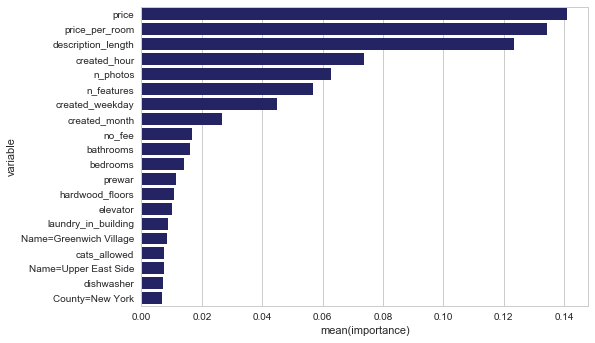

In [14]:
importance = pd.DataFrame({'variable':independent, 'importance':model.feature_importances_})
importance.sort_values(by='importance', ascending=False, inplace=True)
top_importance = importance.head(20)

sns.barplot(y='variable', x='importance', color="midnightblue", data=top_importance)

In [15]:
submission = test[['listing_id']]
prreds, probs = rental_utils.predict(model, test[independent])
submission = pd.concat([submission.reset_index(drop=True), pd.DataFrame(probs, columns=model.classes_)], axis=1)
submission = submission[['listing_id', 'high', 'medium', 'low']]

print(submission.head())

timestamp = str(datetime.datetime.now())[:16]
submission_name = 'Submissions/submission ' + timestamp + '.csv'
submission_name = submission_name.replace(' ', '_').replace(':','')
submission.to_csv(submission_name, index=False)

   listing_id      high    medium       low
0     7142618  0.101748  0.405453  0.492799
1     7210040  0.287790  0.487831  0.224380
2     7174566  0.004258  0.053741  0.942001
3     7191391  0.389549  0.361264  0.249186
4     7171695  0.006161  0.127819  0.866020
